In [2]:
!python -m venv new_env
!source new_env/bin/activate

## Cell 1: Imports and Setup

In [3]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


/Users/ye/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Directory containing .h5ad files (update this path)
data_dir = Path("../data/dataset")

# List all .h5ad files
all_files = sorted([f for f in data_dir.glob("*.h5ad")])
print(f"Total files found: {len(all_files)}")

Total files found: 89


In [38]:
adata = sc.read_h5ad(all_files[0])
print(adata)

AnnData object with n_obs × n_vars = 19293 × 2000
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in month

In [ ]:
meta_data = pd.read_excel("../data/sea-ad_cohort_donor_metadata_072524.xlsx")
selected_samples = meta_data["Donor ID"][meta_data["Last CASI Score"] != np.nan]
print(f'{len(selected_samples)} donors remain.')

84
84 donors remain.


## Cell 2: Select Balanced Subset of Samples

In [41]:
from tqdm import tqdm
# Function to load metadata and determine dementia status
def get_dementia_status(file_path):
    adata = sc.read_h5ad(file_path)
    # Assuming 'dementia_status' is in adata.obs (adjust if different)
    status = adata.obs['Cognitive Status'].iloc[0]  # Assume uniform status per file
    return status

# Categorize files
dementia_files = []
no_dementia_files = []
young_files = []

for i in tqdm(range(len(all_files)), desc = "Processing"):
    f = all_files[i]
    status = get_dementia_status(f)
    if status == 'Dementia':
        dementia_files.append(f)
    elif status == 'No dementia':
        no_dementia_files.append(f)
    else:  # Assuming 'young' or similar for reference
        young_files.append(f)

print(f"Dementia: {len(dementia_files)}, No dementia: {len(no_dementia_files)}, Young: {len(young_files)}")

# Select a balanced subset (e.g., 4 dementia, 4 no dementia, 2 young)
n_samples = {'Dementia': 4, 'No dementia': 4, 'young': 2}
selected_files = (
    np.random.choice(dementia_files, min(n_samples['Dementia'], len(dementia_files)), replace=False).tolist() +
    np.random.choice(no_dementia_files, min(n_samples['No dementia'], len(no_dementia_files)), replace=False).tolist() +
    np.random.choice(young_files, min(n_samples['young'], len(young_files)), replace=False).tolist()
)

print(f"Selected {len(selected_files)} files: {selected_files}")

Processing: 100%|██████████| 89/89 [02:02<00:00,  1.38s/it]

Dementia: 42, No dementia: 42, Young: 5
Selected 10 files: [PosixPath('../data/dataset/H20.33.038_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H21.33.016_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H20.33.026_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H21.33.017_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H21.33.022_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H20.33.019_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H20.33.044_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H20.33.012_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H18.30.001_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad'), PosixPath('../data/dataset/H18.30.002_SEAAD_MTG_RNAseq_final-nuclei.2024-02-13_2000.h5ad')]


## Cell 3: Load and Merge Data with Subsampling

In [7]:
# Load and concatenate files, subsampling if too large
adatas = []
sample_cells = 2000
for file in all_files:
    adata = sc.read_h5ad(file)
    # Subsample cells per file if too large (adjust as needed)
    if adata.n_obs > sample_cells:
        sc.pp.subsample(adata, n_obs=sample_cells, random_state=42)
    # Add sample ID to obs
    sample_id = file.stem  # Extract filename without extension
    adata.obs['sample_id'] = sample_id
    adatas.append(adata)

# Concatenate all datasets
ref_adata = sc.concat(adatas, join='outer', label='sample_id')
print(f"Combined dataset: {ref_adata.shape}")

# Ensure dementia status is preserved in obs
ref_adata.obs['Cognitive Status'] = ref_adata.obs['Cognitive Status'].astype('category')

Combined dataset: (177837, 2000)


## Cell 4: Preprocessing and Clustering

In [8]:
# Basic preprocessing
sc.pp.normalize_total(ref_adata, target_sum=1e4)  # Normalize to 10,000 counts per cell
sc.pp.log1p(ref_adata)  # Log-transform
sc.pp.pca(ref_adata, n_comps=50)  # PCA with 50 components
sc.pp.neighbors(ref_adata, n_neighbors=10, n_pcs=50)  # Compute neighborhood graph

# Clustering with Leiden algorithm
sc.tl.leiden(ref_adata, resolution=0.5, key_added='leiden')  # Adjust resolution as needed
print(f"Number of clusters: {len(ref_adata.obs['leiden'].cat.categories)}")

# Compute UMAP for visualization
sc.tl.umap(ref_adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_75216/1076825034.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ref_adata, resolution=0.5, key_added='leiden')  # Adjust resolution as needed


Number of clusters: 29


## Cell 5: Visualize Clusters and Dementia Status

<Figure size 1000x600 with 0 Axes>

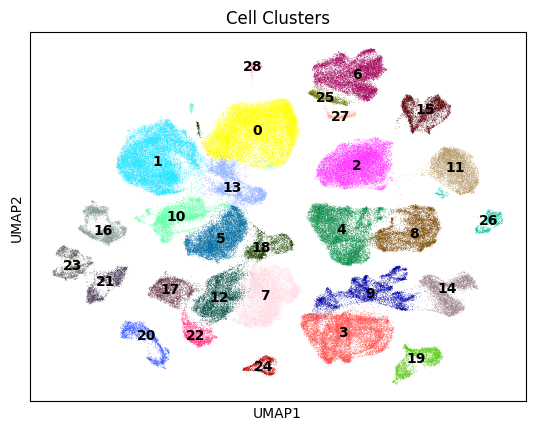

<Figure size 1000x600 with 0 Axes>

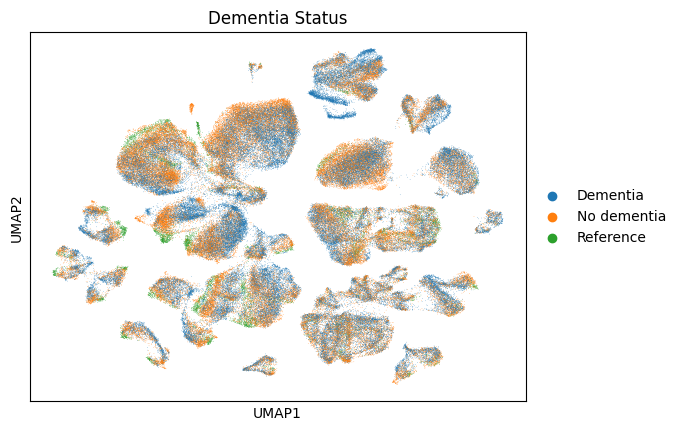

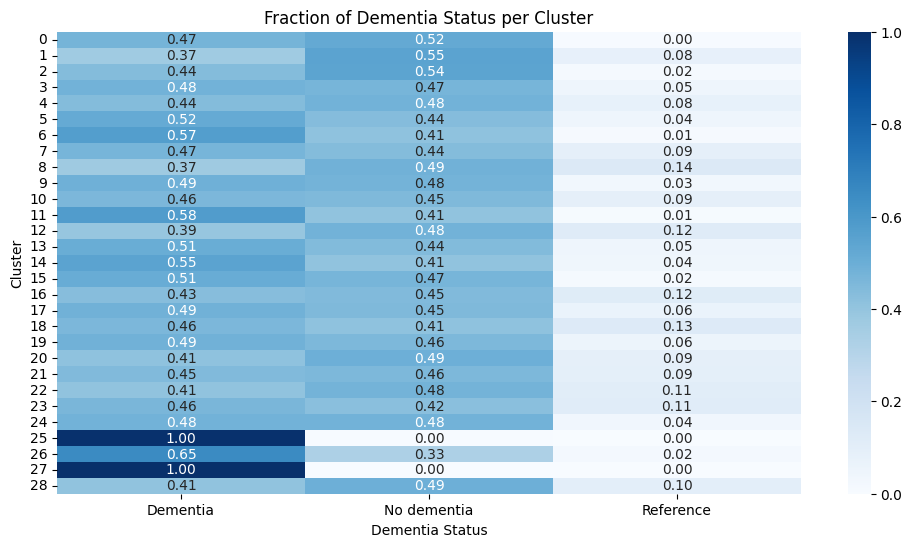

In [12]:
# Plot UMAP with cluster labels
plt.figure(figsize=(10, 6))
sc.pl.umap(ref_adata, color='leiden', legend_loc='on data', title='Cell Clusters', show=False)
plt.show()

# Plot UMAP with dementia status
plt.figure(figsize=(10, 6))
sc.pl.umap(ref_adata, color='Cognitive Status', title='Dementia Status', show=False)
plt.show()

# Calculate and visualize cluster composition
cluster_composition = pd.crosstab(ref_adata.obs['leiden'], ref_adata.obs['Cognitive Status'], normalize='index')
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_composition, annot=True, cmap='Blues', fmt='.2f')
plt.title('Fraction of Dementia Status per Cluster')
plt.xlabel('Dementia Status')
plt.ylabel('Cluster')
plt.show()

## Deal with all samples

In [13]:
cluster_means = {}
for cluster in ref_adata.obs['leiden'].unique():
    cluster_cells = ref_adata[ref_adata.obs['leiden'] == cluster]
    cluster_means[cluster] = np.mean(cluster_cells.X, axis=0).A1  # Convert to 1D array if sparse
cluster_means_df = pd.DataFrame(cluster_means, index=ref_adata.var_names)
print("Cluster means calculated.")
cluster_means_df.shape

Cluster means calculated.


(2000, 29)

In [14]:
from scipy.spatial.distance import cdist
# Step 2: Initialize DataFrame to Store Mean Expressions
patient_cluster_expr_df = pd.DataFrame()

# Step 3: Process Each File Individually
for i in tqdm(range(len(all_files)), desc = "Processing:"):
    file = all_files[i]
    adata = sc.read_h5ad(file)
    sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to 10,000 counts per cell
    sc.pp.log1p(adata)
    sample_id = file.stem
    adata.obs['sample_id'] = sample_id
    # Assign cluster labels based on similarity to reference means
    distances = cdist(adata.X.toarray(), cluster_means_df.T.values, metric='euclidean')
    adata.obs['leiden'] = [cluster_means_df.columns[np.argmin(dist)] for dist in distances] 

    # Compute and store mean expression per cluster
    rows = []
    for cluster in adata.obs['leiden'].unique():
        cluster_cells = adata[adata.obs['leiden'] == cluster]
        mean_expr = np.mean(cluster_cells.X, axis=0).A1  # Convert to 1D array if sparse
        row_dict = {'sample_id': sample_id, 'cluster': cluster}
        for gene, value in zip(adata.var_names, mean_expr):
            row_dict[gene] = value
        rows.append(row_dict)

    # Append means to DataFrame and clear memory
    patient_cluster_expr_df = pd.concat([patient_cluster_expr_df, pd.DataFrame(rows)], ignore_index=True)
    del adata  # Free memory after processing each file

# Step 4: Add Cognitive Status (Assuming it's in adata.obs and consistent per file)
sample_status = {}
for file in all_files:
    adata = sc.read_h5ad(file)
    sample_status[file.stem] = adata.obs['Cognitive Status'].iloc[0]  # Take first value
    del adata  # Free memory
patient_cluster_expr_df['Cognitive Status'] = patient_cluster_expr_df['sample_id'].map(sample_status)

print("All files processed.")
# Save to CSV
patient_cluster_expr_df.to_csv("patient_cluster_expression.csv", index=False)
print("Saved to 'patient_cluster_expression.csv'")


Processing:: 100%|██████████| 89/89 [03:58<00:00,  2.68s/it]


All files processed.
Saved to 'patient_cluster_expression.csv'


In [15]:
print(patient_cluster_expr_df.shape)

(2449, 2003)


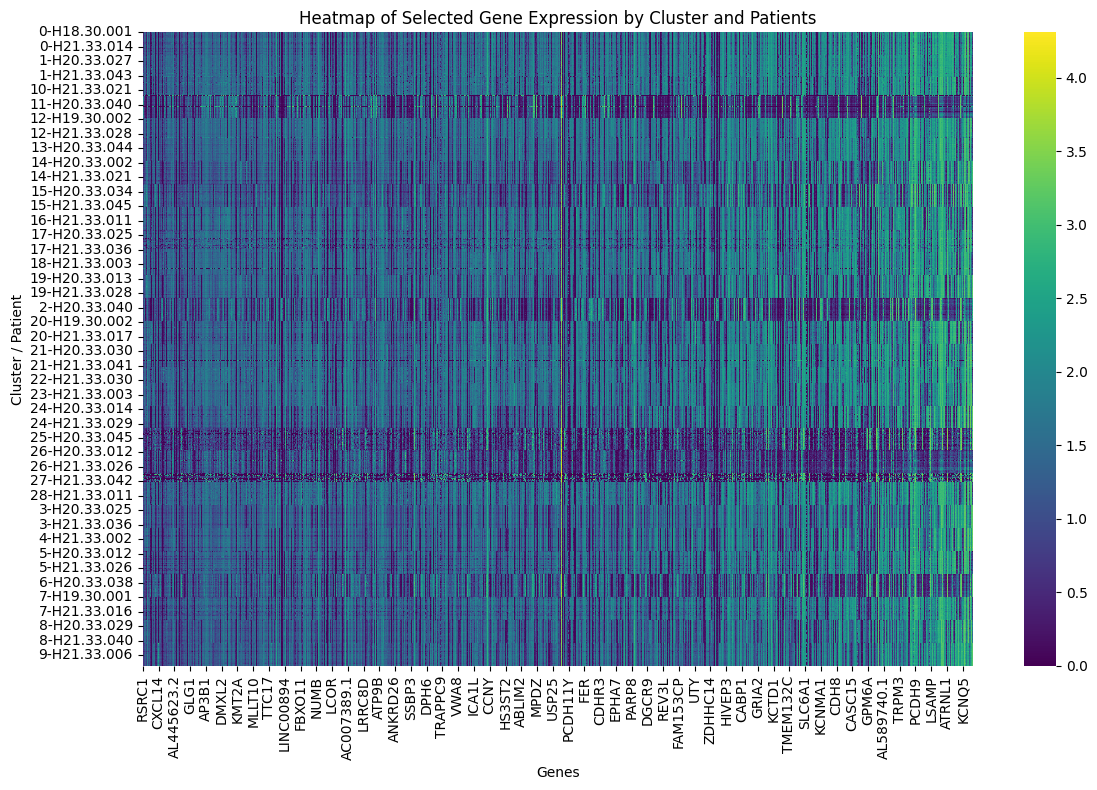

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
patient_cluster_expr_df['sample_id'] = patient_cluster_expr_df['sample_id'].str.split('_').str[0]
# Pivot the DataFrame to have a multi-index of [cluster, sample_id]
pivot_df = patient_cluster_expr_df.set_index(['cluster', 'sample_id'])

# Sort the pivot table by cluster then patient for clear grouping
pivot_df = pivot_df.sort_index(level=['cluster', 'sample_id'])

plt.figure(figsize=(12, 8))
red_green = mcolors.LinearSegmentedColormap.from_list("red_green", ["red", "green"])
sns.heatmap(pivot_df.drop(columns = ["Cognitive Status"]), cmap="viridis",annot=False)
plt.title("Heatmap of Selected Gene Expression by Cluster and Patients")
plt.xlabel("Genes")
plt.ylabel("Cluster / Patient")
plt.tight_layout()
plt.show()

In [ ]:
score = meta_data[["Donor ID","Last CASI Score"]]
score["Last CASI Score"] = score["Last CASI Score"].fillna(meta_data["Last CASI Score"].mean())
young_donors = set(patient_cluster_expr_df["sample_id"].tolist()) - set(meta_data["Donor ID"].tolist())
# Create a new DataFrame from young_donors with a constant score of 100 for each donor.
new_rows = pd.DataFrame({
    "Donor ID": list(young_donors),
    "Last CASI Score": [100] * len(young_donors)
})

# Append the new rows to meta_data using pd.concat
score = pd.concat([score, new_rows], ignore_index=True)


/var/folders/yk/2j5cfqyd7kj0kyn2bcjzg4lr0000gn/T/ipykernel_75216/1589864637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score["Last CASI Score"] = score["Last CASI Score"].fillna(meta_data["Last CASI Score"].mean())


[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 9

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

y = [float(score[score["Donor ID"] == sample_id]["Last CASI Score"].tolist()[0]) for sample_id in patient_cluster_expr_df["sample_id"].tolist()]
X = patient_cluster_expr_df.iloc[:,2:-1]
# Create a linear regression model
model = LinearRegression()

# Define 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross_val_score (using R² as the scoring metric)
scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

print("5-Fold Cross-Validation R² Scores:", scores)
print("Mean R² Score:", np.mean(scores))

5-Fold Cross-Validation R² Scores: [-133.63054606  -69.72438549  -42.27559251  -60.35228153  -51.40189555]
Mean R² Score: -71.47694023084728


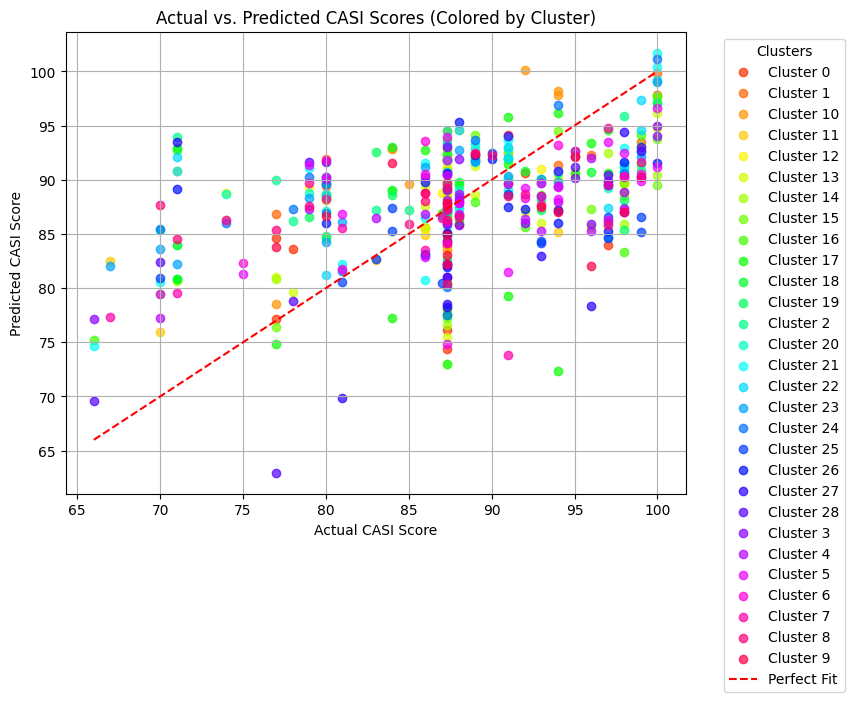

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Define y (target variable) and X (feature matrix)
y = np.array([
    float(score[score["Donor ID"] == sample_id]["Last CASI Score"].tolist()[0])
    for sample_id in patient_cluster_expr_df["sample_id"].tolist()
])
# X = patient_cluster_expr_df.iloc[:, 2:-1]  # Select relevant features

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(patient_cluster_expr_df, y, test_size=0.2, random_state=42)
clusters = X_test["cluster"]
X_train = X_train.iloc[:, 2:-1]
X_test = X_test.iloc[:, 2:-1]
# Create a pipeline: Standardize data and apply Linear Regression with modified parameters
model = make_pipeline(
    #StandardScaler(),  # Standardizes features (mean=0, variance=1)
    LinearRegression(fit_intercept=True, n_jobs=-1, positive=True)  # Forces positive coefficients
)

# Train the model
model.fit(X_train, y_train)

# Predict CASI scores
y_pred = model.predict(X_test)

# Plot actual vs. predicted CASI scores

# Assuming `clusters` is a Pandas Series or array storing cluster labels for y_test
unique_clusters = np.unique(clusters)  # Get unique cluster labels
palette = sns.color_palette("hsv", len(unique_clusters))  # Generate distinct colors

# Create a mapping from cluster label to color
cluster_color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Plot each cluster with a different color
plt.figure(figsize=(8, 6))
for cluster in unique_clusters:
    cluster_mask = (clusters == cluster)  # Mask for current cluster
    plt.scatter(
        y_test[cluster_mask], y_pred[cluster_mask],
        alpha=0.7, label=f"Cluster {cluster}", color=cluster_color_map[cluster]
    )

# Perfect fit line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label="Perfect Fit")

# Labels and title
plt.xlabel("Actual CASI Score")
plt.ylabel("Predicted CASI Score")
plt.title("Actual vs. Predicted CASI Scores (Colored by Cluster)")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.grid(True)

plt.show()


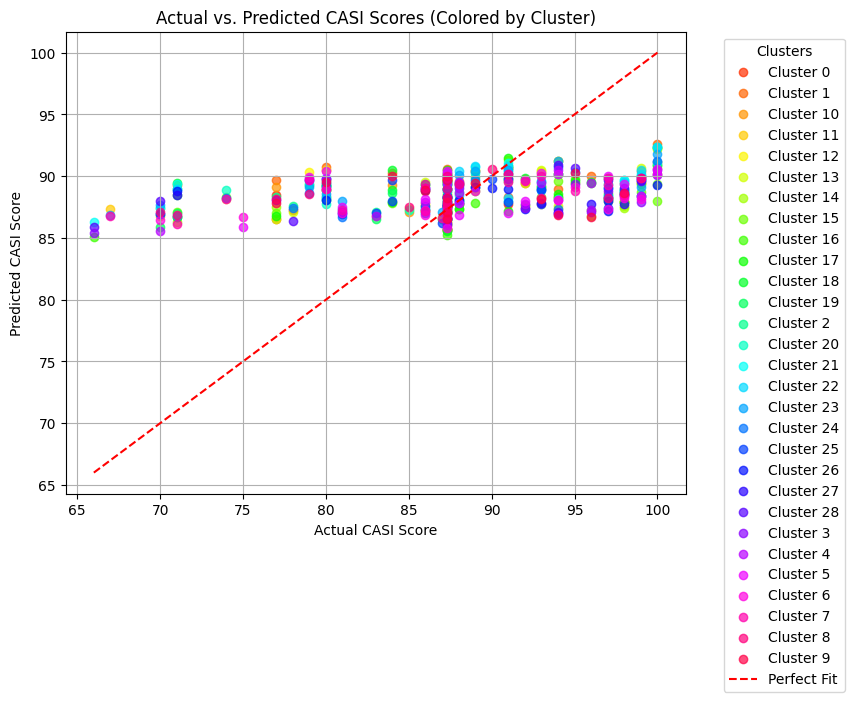

In [106]:

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Define y (target variable) and X (feature matrix)
y = np.array([
    float(score[score["Donor ID"] == sample_id]["Last CASI Score"].tolist()[0])
    for sample_id in patient_cluster_expr_df["sample_id"].tolist()
])
# X = patient_cluster_expr_df.iloc[:, 2:-1]  # Select relevant features

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(patient_cluster_expr_df, y, test_size=0.2, random_state=42)
clusters = X_test["cluster"]
X_train = X_train.iloc[:, 2:-1]
X_test = X_test.iloc[:, 2:-1]
# Create a pipeline: Standardize data and apply Linear Regression with modified parameters
# Create an SVM pipeline with standardization
svm_model = make_pipeline(
    #StandardScaler(),  # Standardizes features (mean=0, variance=1)
    SVR(kernel="rbf", C=1.0, epsilon=0.1)  # Radial Basis Function (RBF) kernel
)


# Train the model
svm_model.fit(X_train, y_train)

# Predict CASI scores
y_pred = svm_model.predict(X_test)

# Plot actual vs. predicted CASI scores

# Assuming `clusters` is a Pandas Series or array storing cluster labels for y_test
unique_clusters = np.unique(clusters)  # Get unique cluster labels
palette = sns.color_palette("hsv", len(unique_clusters))  # Generate distinct colors

# Create a mapping from cluster label to color
cluster_color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Plot each cluster with a different color
plt.figure(figsize=(8, 6))
for cluster in unique_clusters:
    cluster_mask = (clusters == cluster)  # Mask for current cluster
    plt.scatter(
        y_test[cluster_mask], y_pred[cluster_mask],
        alpha=0.7, label=f"Cluster {cluster}", color=cluster_color_map[cluster]
    )

# Perfect fit line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', label="Perfect Fit")

# Labels and title
plt.xlabel("Actual CASI Score")
plt.ylabel("Predicted CASI Score")
plt.title("Actual vs. Predicted CASI Scores (Colored by Cluster)")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.grid(True)

plt.show()



In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Define y (target variable) and X (feature matrix)
y = np.array([
    float(score[score["Donor ID"] == sample_id]["Last CASI Score"].tolist()[0])
    for sample_id in patient_cluster_expr_df["sample_id"].tolist()
])
X = patient_cluster_expr_df.iloc[:, 2:-1]  # Select relevant features

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Lasso with automatic alpha selection using cross-validation
lasso_model = make_pipeline(
    #StandardScaler(),  # Standardizes features (mean=0, variance=1)
    LassoCV(cv=5, alphas=np.logspace(-2, 1, 50), max_iter=10000,random_state=42)  # Search for best alpha
)

# Train the model
lasso_model.fit(X_train, y_train)

# Predict CASI scores
y_pred = lasso_model.predict(X_test)

# Compute cross-validation scores
cv_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')
print(f"5-Fold Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {np.mean(cv_scores):.2f}")

# Get the best alpha (regularization strength) chosen by LassoCV
best_alpha = lasso_model.named_steps['lassocv'].alpha_
print(f"Best alpha (regularization strength) chosen: {best_alpha:.4f}")

# Plot actual vs. predicted CASI scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs. Actual", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

# Labels and title
plt.xlabel("Actual CASI Score")
plt.ylabel("Predicted CASI Score")
plt.title(f"Actual vs. Predicted CASI Scores (Lasso Regression, α={best_alpha:.4f})")
plt.legend()
plt.grid(True)

# Display R² Score
r2 = r2_score(y_test, y_pred)
plt.text(min(y_test), max(y_pred), f"R² Score: {r2:.2f}", fontsize=12, color="black")

plt.show()


/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.920e+01, tolerance: 1.139e+01
  model = cd_fast.enet_coordinate_descent(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.907e+01, tolerance: 1.139e+01
  model = cd_fast.enet_coordinate_descent(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

KeyboardInterrupt: 

## Feature selection

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define y (target variable) and X (feature matrix)
y = np.array([
    float(score[score["Donor ID"] == sample_id]["Last CASI Score"].tolist()[0])
    for sample_id in patient_cluster_expr_df["sample_id"].tolist()
])
X = patient_cluster_expr_df.iloc[:, 2:-1]  # Select relevant features

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest to get feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Select the top 20 most important features
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features = feature_importances.nlargest(100).index  # Select top 20 features

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Number of selected features: {len(selected_features)}")
print(f"Selected features: {list(selected_features)}")


Number of selected features: 100
Selected features: ['MT-ATP6', 'PLCG2', 'MT-ND1', 'LINC00486', 'KANSL1', 'MTRNR2L12', 'MT-ND3', 'NUTM2A-AS1', 'ARL17B', 'COL4A5', 'AC098829.1', 'PLP1', 'PDE10A', 'ARHGAP35', 'ST18', 'SLC1A3', 'DPH6', 'USP9Y', 'JPH4', 'GMDS-DT', 'MIR4300HG', 'RUFY3', 'BICRAL', 'XIST', 'UBA6-AS1', 'GAPDH', 'CASTOR3', 'NLGN4Y', 'TERF2IP', 'AF165147.1', 'YWHAZ', 'HDAC8', 'MT-CO2', 'CERS4', 'TAPT1-AS1', 'LINC00342', 'BPTF', 'AL356295.1', 'POLR2F', 'AC006504.5', 'AC093607.1', 'HSPH1', 'RFX4', 'SPP1', 'TMEM14B', 'SESN1', 'UTY', 'DOCK5', 'RSRP1', 'AC073091.3', 'CCDC7', 'OBI1-AS1', 'BMPR2', 'ACTB', 'STAG1', 'GNAS', 'ENSA', 'HP1BP3', 'CNP', 'CBFA2T2', 'MALAT1', 'CCDC144A', 'IMMP2L', 'ATRX', 'LUC7L2', 'AC016687.2', 'ZNF518A', 'UBE2R2', 'ZHX3', 'GRIN1', 'ANKRD36C', 'RPRD2', 'TTC3', 'TRA2A', 'BCAS1', 'HSP90AB1', 'WSB1', 'MIB1', 'HSP90AA1', 'MOG', 'LUC7L3', 'GPI', 'LINC02263', 'LINC00499', 'PDS5A', 'MT-ND2', 'FTL', 'ZNF638', 'LARP1', 'AATK', 'CERCAM', 'USP47', 'FAF1', 'LINC01608', 'P

In [113]:
# Train SVR model using selected features
svr_model = make_pipeline(
    StandardScaler(),
    SVR(kernel="rbf", C=1.0, epsilon=0.1)
)

svr_model.fit(X_train_selected, y_train)

# Predict CASI scores
y_pred = svr_model.predict(X_test_selected)

# Compute cross-validation scores
cv_scores = cross_val_score(svr_model, X_train_selected, y_train, cv=5, scoring='r2')
print(f"5-Fold Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {np.mean(cv_scores):.2f}")


5-Fold Cross-Validation R² Scores: [0.25448898 0.26716419 0.29318747 0.26750898 0.25203974]
Mean R² Score: 0.27


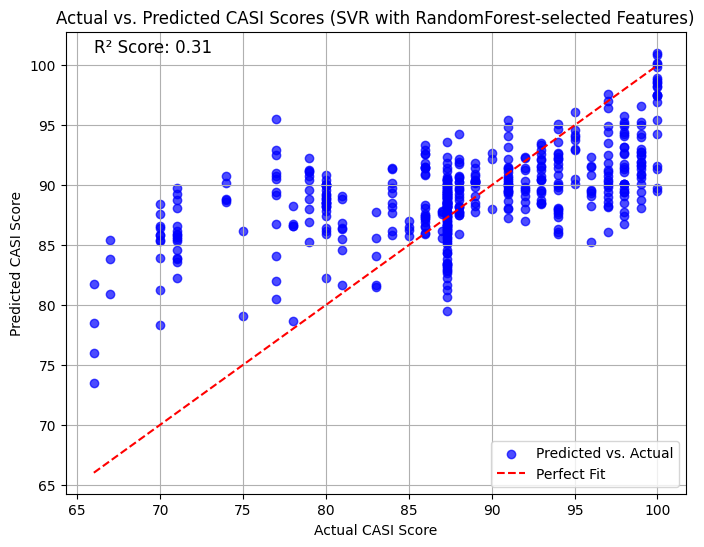

In [111]:
# Scatter plot of Actual vs. Predicted CASI Scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs. Actual", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

# Labels and title
plt.xlabel("Actual CASI Score")
plt.ylabel("Predicted CASI Score")
plt.title("Actual vs. Predicted CASI Scores (SVR with RandomForest-selected Features)")
plt.legend()
plt.grid(True)

# Display R² Score
r2 = r2_score(y_test, y_pred)
plt.text(min(y_test), max(y_pred), f"R² Score: {r2:.2f}", fontsize=12, color="black")

plt.show()


## Two dimensional clustering test

In [17]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from pathlib import Path
print(patient_cluster_expr_df.shape)
patient_cluster_expr_df.head()


(2449, 2003)


sample_id cluster     RSRC1     RNGTT     LIMS1     MAPK1       KIZ  \
0  H18.30.001       4  0.970170  1.263354  0.838558  1.147374  1.060665   
1  H18.30.001       8  0.825118  1.349264  0.667858  1.238609  1.382767   
2  H18.30.001      16  0.903605  1.283793  1.010340  1.376808  1.137898   
3  H18.30.001      18  0.979580  1.427699  0.702265  1.356438  1.224099   
4  H18.30.001      17  0.954010  1.447479  0.824023  1.501975  1.214280   

       SACS    RNF180     TRA2A  ...  IQCJ-SCHIP1      SGCZ     CNTN5  \
0  1.452543  1.388488  1.520109  ...     2.164565  2.584202  2.497088   
1  0.878056  1.384649  1.552100  ...     1.847755  1.349262  2.203564   
2  1.517957  1.087224  1.646121  ...     2.979232  2.606994  2.060008   
3  1.204944  1.093107  1.591838  ...     2.818124  2.059093  2.797749   
4  1.377616  1.121902  1.656706  ...     2.714961  2.296492  1.411628   

      RALYL     DPP10    ADARB2     ROBO2    KCNIP4     ERBB4  \
0  0.922136  2.929493  0.110719  2.112217  2.034220  3.260510   
1  2.781263  1.967485  0.154863  3.164713  2.547177  1.350241   
2  2.893705  2.866162  0.119611  2.438407  3.383458  0.616029   
3  2.953413  2.732925  0.145360  1.307847  3.257901  0.559920   
4  2.846758  2.966048  0.122320  2.706741  3.185112  0.579744   

   Cognitive Status  
0         Reference  
1         Reference  
2         Reference  
3         Reference  
4         Reference  

[5 rows x 2003 columns]

In [18]:
num_signatures = len(patient_cluster_expr_df.columns.tolist()[2:-1])
num_cells = len(patient_cluster_expr_df)
expression_array = np.array(patient_cluster_expr_df.iloc[:,2:-1])
# Row-wise error (variance and standard deviation for each row)
experiment_variance = expression_array.var(axis=1)  # Variance row-wise
experiment_std_dev = expression_array.std(axis=1)   # Standard deviation row-wise
# Column-wise error (variance and standard deviation for each column)
signature_variance = expression_array.var(axis=0)  # Variance column-wise
signature_std_dev = expression_array.std(axis=0) # Standard deviation column-wise


In [19]:
signature_distance_array =  np.zeros((num_signatures, num_signatures))
# Step 1: Normalize the expression array by dividing each column by its standard deviation.
norm_expr_sign = expression_array / signature_std_dev[np.newaxis, :]

# Step 2: Compute the Euclidean norms of each normalized column.
column_norms_sign = np.linalg.norm(norm_expr_sign, axis=0)

# Step 3: Compute the dot product between all pairs of normalized columns.
dot_products_sign = norm_expr_sign.T @ norm_expr_sign  # Shape: (num_signatures, num_signatures)

# Step 4: Compute the correlation matrix.
# Avoid division by zero by ensuring signature_std_dev are non-zero.
correlation_matrix_signature = dot_products_sign / (column_norms_sign[:, None] * column_norms_sign[None, :])

# Step 5: Compute the distance matrix.
signature_distance_array = 1 - correlation_matrix_signature

In [20]:
cell_distance_array =  np.zeros((num_cells, num_cells))
# Step 1: Normalize the expression array by dividing each column by its standard deviation.
norm_expr_cell = expression_array.T / experiment_std_dev[np.newaxis, :]

# Step 2: Compute the Euclidean norms of each normalized column.
column_norms_cell = np.linalg.norm(norm_expr_cell, axis=0)

# Step 3: Compute the dot product between all pairs of normalized columns.
dot_products_cell = norm_expr_cell.T @ norm_expr_cell  # Shape: (num_signatures, num_signatures)

# Step 4: Compute the correlation matrix.
# Avoid division by zero by ensuring signature_std_dev are non-zero.
correlation_matrix_cell = dot_products_cell / (column_norms_cell[:, None] * column_norms_cell[None, :])

# Step 5: Compute the distance matrix.
cell_distance_array = 1 - correlation_matrix_cell

In [21]:
row_linkage = linkage(pdist(cell_distance_array), method='average')
row_dendro = dendrogram(row_linkage, no_plot=True)

# Cluster columns (genes)
col_linkage = linkage(pdist(signature_distance_array), method='average')
col_dendro = dendrogram(col_linkage, no_plot=True)


# Reorder data based on clustering
clustered_data = patient_cluster_expr_df.iloc[row_dendro['leaves'],[0,1,patient_cluster_expr_df.shape[1]-1] + [leave + 2 for leave in col_dendro['leaves']]]
clustered_data.head()

sample_id cluster Cognitive Status     HTR2C    CXCL14      RELN  \
42    H18.30.002      11        Reference  0.017566  0.034450  0.019912   
102   H19.30.002      11        Reference  0.021424  0.154649  0.068761   
72    H19.30.001      11        Reference  0.032374  0.105841  0.025425   
1714  H21.33.020      11         Dementia  0.000000  0.000000  0.000000   
2118  H21.33.035      27      No dementia  0.000000  0.000000  0.000000   

          GAD2  DLX6-AS1     PDGFD  NR2F2-AS1  ...      FIGN   RHOBTB3  \
42    0.038721  0.018334  0.037930   0.019868  ...  0.000000  0.074270   
102   0.021642  0.021349  0.010327   0.000000  ...  0.073136  0.198529   
72    0.039366  0.074055  0.004377   0.004320  ...  0.038882  0.179481   
1714  0.000000  0.000000  0.000000   0.000000  ...  0.021353  0.366338   
2118  0.000000  0.000000  0.000000   0.000000  ...  0.000000  3.198775   

          LIFR  LMCD1-AS1      DLC1     PDE4B     KLHL5   ANKRD44     PELI2  \
42    0.015230   0.078406  0.036959  1.706300  1.313272  2.822132  1.108289   
102   0.021636   0.250403  0.184407  2.400985  1.738921  3.211272  1.073560   
72    0.030892   0.114093  0.168537  1.738758  1.476871  3.099269  0.962857   
1714  0.067581   0.071711  0.191340  2.634694  1.647432  2.595781  0.927441   
2118  2.906203   0.000000  3.440635  0.000000  0.000000  0.000000  0.000000   

        CHST11  
42    3.176276  
102   3.047144  
72    3.126081  
1714  3.396424  
2118  0.000000  

[5 rows x 2003 columns]

In [22]:
# Step 4: Prepare Sidebars
# Cluster labels

cluster_labels = patient_cluster_expr_df['cluster'].unique()
cluster_colors = {cluster: sns.color_palette("husl", len(cluster_labels))[i] 
                  for i, cluster in enumerate(cluster_labels)}
# Dementia status (example mapping, adjust based on your data)
# Assume dementia status is in adata.obs or can be mapped to clusters
# Here, we simulate it; replace with actual metadata

dementia_colors = {'Dementia': 'red', 'No dementia': 'blue', "Reference":'black'}

# Create row colors for sidebars
row_colors = pd.DataFrame({
    'Cluster': [cluster_colors[cluster] for cluster in patient_cluster_expr_df['cluster']],
    'Dementia': [dementia_colors[status] for status in patient_cluster_expr_df['Cognitive Status']]
})

<Figure size 1500x1000 with 0 Axes>

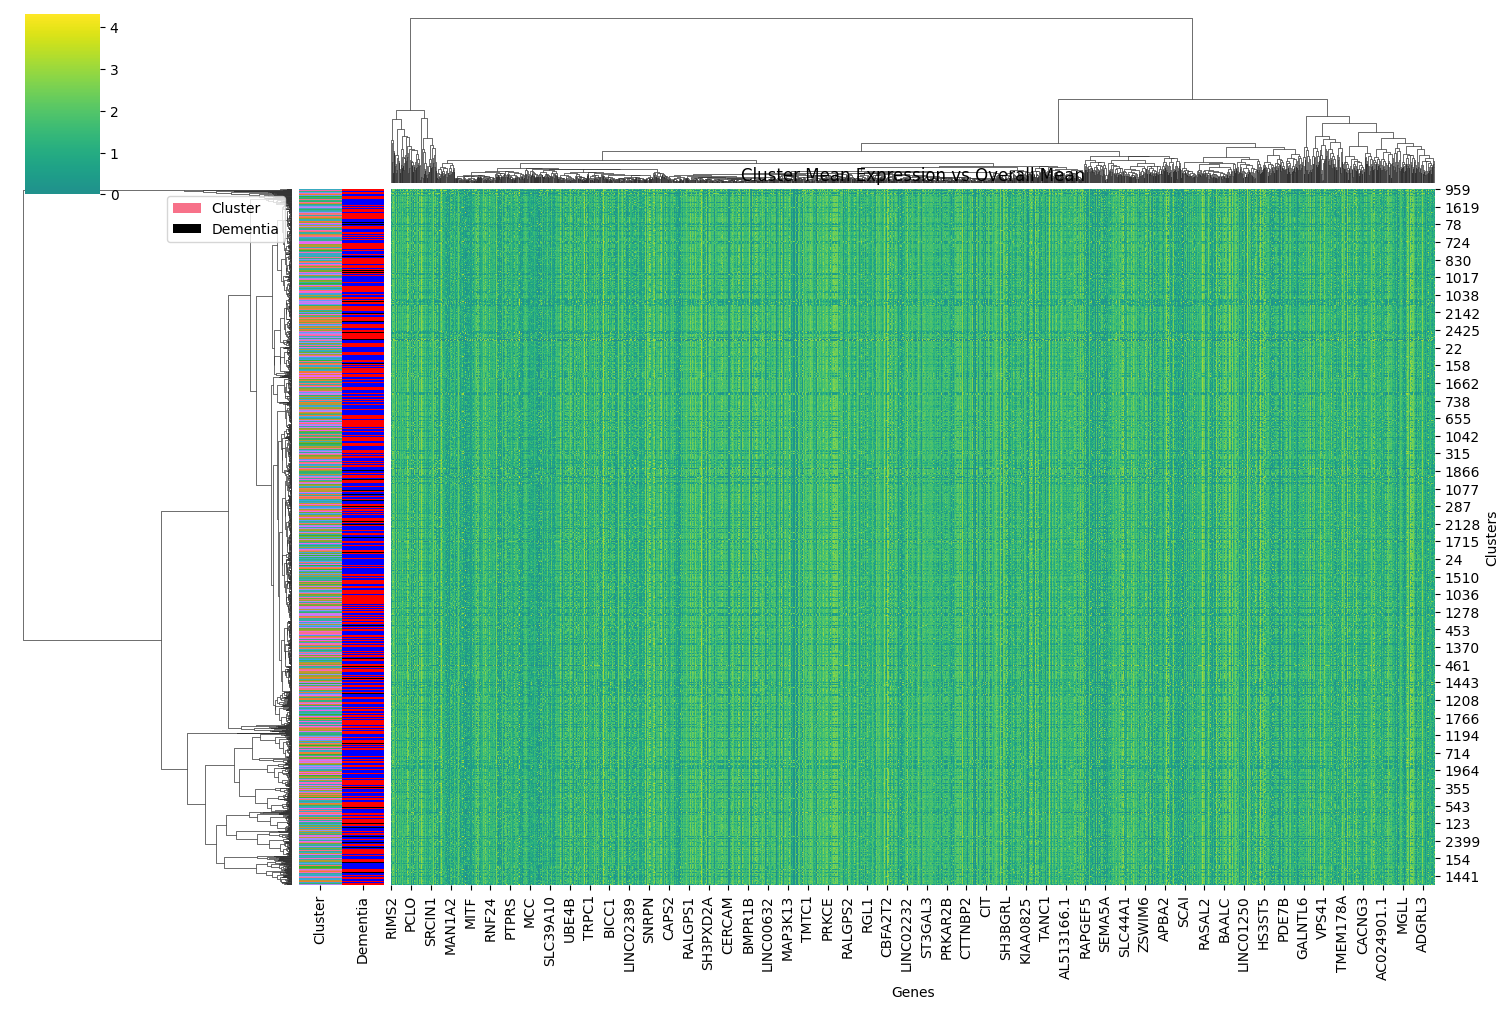

In [24]:
# Step 5: Visualize
plt.figure(figsize=(15, 10))
g = sns.clustermap(
    clustered_data.iloc[:,3:],
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    row_colors=row_colors,
    cmap='viridis',
    center=0,
    figsize=(15, 10),
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(0.02, 0.8, 0.05, 0.18)
)
g.ax_heatmap.set_title("Cluster Mean Expression vs Overall Mean")
g.ax_heatmap.set_xlabel("Genes")
g.ax_heatmap.set_ylabel("Clusters")

# Add legend for sidebars
for label in ['Cluster', 'Dementia']:
    g.ax_row_dendrogram.bar(0, 0, color=row_colors[label].unique()[0], label=label)
g.ax_row_dendrogram.legend(loc='upper right', ncol=1)

plt.show()

# Cluseter Respectively

In [ ]:
var_names = patient_cluster_expr_df.columns[2:-1]
gene_mean = np.mean(patient_cluster_expr_df[var_names])
cell_mean = np.mean(patient_cluster_expr_df[var_names],axis = 1)


In [ ]:
diff_cluster_vs_overall = patient_cluster_expr_df[var_names].sub(gene_mean, axis=0)
diff_gene_vs_cluster = patient_cluster_expr_df.sub(cell_mean, axis=1)
# Step 3: Hierarchical Clustering
# Cluster rows (clusters)
row_linkage = linkage(pdist(diff_cluster_vs_overall), method='ward')
row_dendro = dendrogram(row_linkage, no_plot=True)

# Cluster columns (genes)
col_linkage = linkage(pdist(diff_cluster_vs_overall.T), method='ward')
col_dendro = dendrogram(col_linkage, no_plot=True)


In [ ]:

# Reorder data based on clustering
clustered_data = patient_cluster_expr_df.iloc[row_dendro['leaves'],[0,1,patient_cluster_expr_df.shape[1]-1] + [leave + 2 for leave in col_dendro['leaves']]]
clustered_data.head()

sample_id cluster Cognitive Status    RNF220      HHIP  SLC7A14-AS1  \
26    H18.30.001      16        Reference  0.000000  0.000000     0.000000   
1159   H200.1023      16        Reference  0.000000  1.811380     0.000000   
802   H20.33.033      16         Dementia  0.260526  0.029397     0.051950   
1683  H21.33.020      16         Dementia  0.192066  0.074091     0.048317   
1392  H21.33.009      16         Dementia  0.188300  0.071657     0.114976   

          CLMN   TMEM144        TF      PLP1  ...    GARNL3     TENM3  \
26    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
1159  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
802   0.138624  0.000000  0.421452  0.129920  ...  0.396082  0.185824   
1683  0.075052  0.131226  0.344532  0.000000  ...  0.548104  0.076040   
1392  0.176846  0.102681  0.591824  0.428684  ...  0.822269  0.115045   

         TMTC1       PAM     EPHA6   RASGRF2     SLIT2     PRKG1      NFIB  \
26    0.000000  2.409699  2.409699  0.000000  0.000000  0.000000  2.409699   
1159  0.000000  2.487830  0.000000  0.000000  0.000000  0.000000  2.175468   
802   0.121256  0.999410  0.396952  0.114565  0.421608  0.271850  2.412038   
1683  0.045481  1.169961  0.213828  0.075880  0.102412  0.183825  2.386629   
1392  0.227711  1.474095  0.316542  0.238411  0.175387  0.317492  2.274812   

        MGAT4C  
26    0.000000  
1159  0.000000  
802   0.463089  
1683  0.128695  
1392  0.285174  

[5 rows x 2003 columns]

In [ ]:
# Step 4: Prepare Sidebars
# Cluster labels
cluster_labels = clustered_data['cluster'].unique()
cluster_colors = {cluster: sns.color_palette("husl", len(cluster_labels))[i] 
                  for i, cluster in enumerate(cluster_labels)}
# Dementia status (example mapping, adjust based on your data)
# Assume dementia status is in adata.obs or can be mapped to clusters
# Here, we simulate it; replace with actual metadata

dementia_colors = {'Dementia': 'red', 'No dementia': 'blue', "Reference":'black'}

# Create row colors for sidebars
row_colors = pd.DataFrame({
    'Cluster': [cluster_colors[cluster] for cluster in clustered_data['cluster']],
    'Dementia': [dementia_colors[status] for status in clustered_data['Cognitive Status']]
})

<Figure size 1500x1000 with 0 Axes>

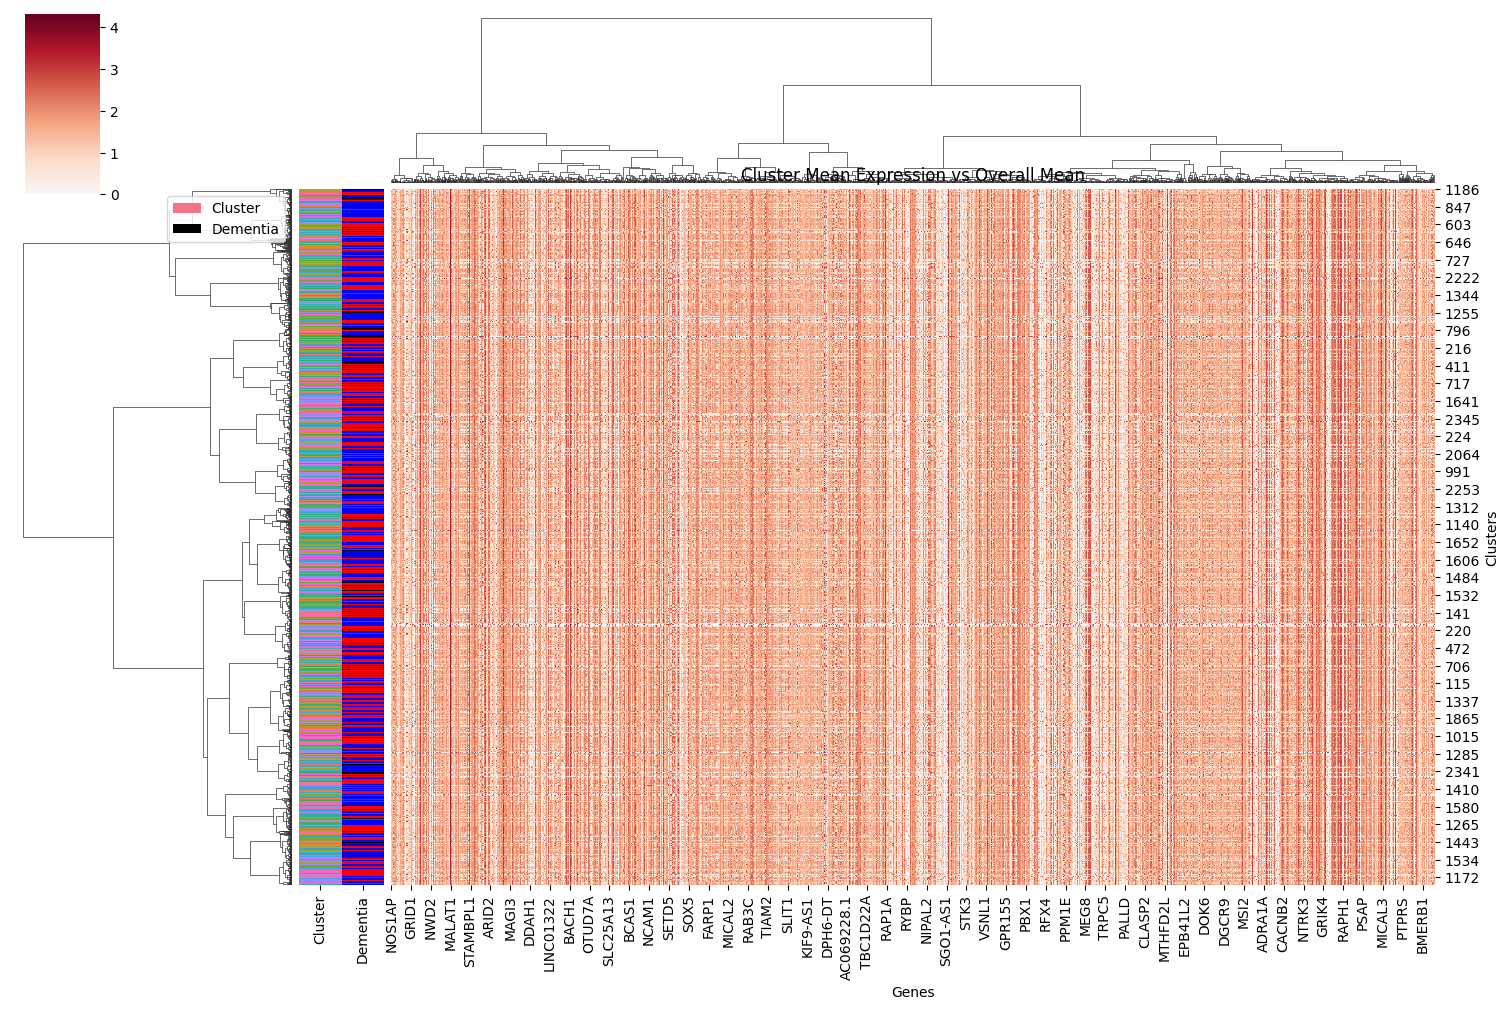

In [ ]:
# Step 5: Visualize
plt.figure(figsize=(15, 10))
g = sns.clustermap(
    clustered_data.iloc[:,3:],
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    row_colors=row_colors,
    cmap='RdBu_r',
    center=0,
    figsize=(15, 10),
    dendrogram_ratio=(0.2, 0.2),
    cbar_pos=(0.02, 0.8, 0.05, 0.18)
)
g.ax_heatmap.set_title("Cluster Mean Expression vs Overall Mean")
g.ax_heatmap.set_xlabel("Genes")
g.ax_heatmap.set_ylabel("Clusters")

# Add legend for sidebars
for label in ['Cluster', 'Dementia']:
    g.ax_row_dendrogram.bar(0, 0, color=row_colors[label].unique()[0], label=label)
g.ax_row_dendrogram.legend(loc='upper right', ncol=1)

plt.show()

In [ ]:
patient_cluster_expr_df.head()

sample_id cluster     RSRC1     RNGTT     LIMS1     MAPK1       KIZ  \
0  H18.30.001       4  0.970054  1.263826  0.838166  1.147179  1.060437   
1  H18.30.001       9  0.825310  1.348692  0.668376  1.238793  1.382888   
2  H18.30.001      17  0.903605  1.283793  1.010340  1.376808  1.137898   
3  H18.30.001      19  0.978583  1.425226  0.701293  1.359082  1.223310   
4  H18.30.001      14  0.954670  1.449403  0.825979  1.501163  1.212897   

       SACS    RNF180     TRA2A  ...  IQCJ-SCHIP1      SGCZ     CNTN5  \
0  1.452330  1.388302  1.519973  ...     2.164615  2.583987  2.498022   
1  0.878548  1.384862  1.552243  ...     1.847836  1.350033  2.202630   
2  1.517957  1.087224  1.646121  ...     2.979232  2.606994  2.060008   
3  1.205223  1.091447  1.591099  ...     2.817916  2.060714  2.799205   
4  1.376736  1.120261  1.658871  ...     2.714405  2.300506  1.408947   

      RALYL     DPP10    ADARB2     ROBO2    KCNIP4     ERBB4  \
0  0.922481  2.930588  0.110760  2.111837  2.034149  3.260592   
1  2.780079  1.966651  0.154798  3.164697  2.547040  1.350957   
2  2.893705  2.866162  0.119611  2.438407  3.383458  0.616029   
3  2.954394  2.732692  0.145608  1.311427  3.258183  0.559209   
4  2.848203  2.970273  0.121769  2.721314  3.185018  0.580711   

   Cognitive Status  
0         Reference  
1         Reference  
2         Reference  
3         Reference  
4         Reference  

[5 rows x 2003 columns]

In [ ]:
cluster_cognitive_counts = df.groupby("cluster")["Cognitive Status"].value_counts().unstack()

# Display the result
print(cluster_cognitive_counts)

## Cluster Prediction

/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.155e-01, tolerance: 3.784e-01
  model = cd_fast.enet_coordinate_descent(


Cluster 4: Best alpha = 0.5964
Cluster 8: Best alpha = 0.7906
Cluster 16: Best alpha = 0.4498
Cluster 18: Best alpha = 0.7906
Cluster 17: Best alpha = 0.3393
Cluster 13: Best alpha = 0.3907
Cluster 20: Best alpha = 0.6866
Cluster 7: Best alpha = 0.3907
Cluster 21: Best alpha = 0.2560
Cluster 24: Best alpha = 0.7906
Cluster 19: Best alpha = 0.4498
Cluster 5: Best alpha = 10.0000
Cluster 28: Best alpha = 0.4498
Cluster 12: Best alpha = 10.0000
Cluster 1: Best alpha = 0.2947
Cluster 0: Best alpha = 0.2560
Cluster 23: Best alpha = 0.6866
Cluster 3: Best alpha = 0.1677
Cluster 14: Best alpha = 0.5964
Cluster 9: Best alpha = 0.5964
Cluster 26: Best alpha = 1.2068
Cluster 10: Best alpha = 10.0000
Cluster 11: Best alpha = 0.6866
Cluster 2: Best alpha = 1.0481
Cluster 6: Best alpha = 0.5964
Cluster 15: Best alpha = 0.9103
Cluster 22: Best alpha = 0.5179
Cluster 25: Best alpha = 10.0000
Cluster 27: Best alpha = 10.0000
R² Score on test set: 0.32


/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X do

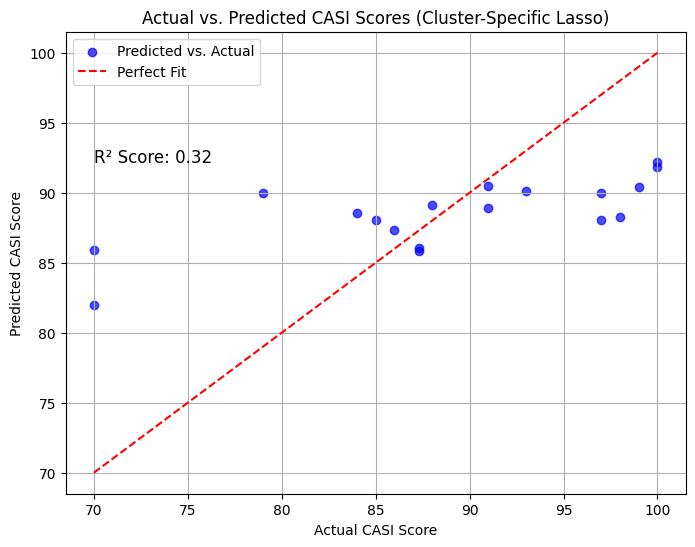

In [115]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'score' is a DataFrame with "Donor ID" and "Last CASI Score"
# and 'patient_cluster_expr_df' has columns: 'sample_id', 'cluster', gene expressions, 'Cognitive Status'

# Step 1: Map CASI scores to patient_cluster_expr_df
casi_dict = score.set_index('Donor ID')['Last CASI Score'].to_dict()
patient_cluster_expr_df['CASI'] = patient_cluster_expr_df['sample_id'].map(casi_dict)

# Step 2: Split data into training and testing sets based on unique sample_ids
unique_samples = patient_cluster_expr_df['sample_id'].unique()
train_samples, test_samples = train_test_split(unique_samples, test_size=0.2, random_state=42)

# Create training and testing DataFrames
train_df = patient_cluster_expr_df[patient_cluster_expr_df['sample_id'].isin(train_samples)]
test_df = patient_cluster_expr_df[patient_cluster_expr_df['sample_id'].isin(test_samples)]

# Step 3: Identify unique clusters
unique_clusters = patient_cluster_expr_df['cluster'].unique()

# Step 4: Train a LassoCV model for each cluster
models = {}
for k in unique_clusters:
    # Select training data for cluster k
    X_k_train = train_df[train_df['cluster'] == k].iloc[:, 2:-2]  # Gene expressions (excluding sample_id, cluster, Cognitive Status, CASI)
    y_k_train = train_df[train_df['cluster'] == k]['CASI']
    
    # Create and train the model
    lasso_model_k = make_pipeline(
        #StandardScaler(),  # Standardize features
        LassoCV(cv=5, alphas=np.logspace(-2, 1, 50), max_iter=10000, random_state=42)  # Alpha selection with cross-validation
    )
    lasso_model_k.fit(X_k_train, y_k_train)
    models[k] = lasso_model_k
    
    # Print the best alpha for this cluster
    best_alpha_k = lasso_model_k.named_steps['lassocv'].alpha_
    print(f"Cluster {k}: Best alpha = {best_alpha_k:.4f}")

# Step 5: Predict CASI scores for test samples
y_pred_list = []
y_test_list = []

for s in test_samples:
    # Get all rows (clusters) for this test sample
    rows_s = test_df[test_df['sample_id'] == s]
    predictions_s = []
    
    # Predict using the model for each cluster in the sample
    for index, row in rows_s.iterrows():
        ki = row['cluster']
        x_ki = row[2:-2].values.reshape(1, -1)  # Reshape for single-sample prediction
        p_ki = models[ki].predict(x_ki)[0]
        predictions_s.append(p_ki)
    
    # Average the predictions for this sample
    predicted_casi_s = np.mean(predictions_s)
    y_pred_list.append(predicted_casi_s)
    y_test_list.append(rows_s['CASI'].iloc[0])  # CASI is the same for all rows of the sample

# Convert to numpy arrays
y_pred = np.array(y_pred_list)
y_test = np.array(y_test_list)

# Step 6: Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R² Score on test set: {r2:.2f}")

# Step 7: Plot actual vs. predicted CASI scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs. Actual", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

# Labels and title
plt.xlabel("Actual CASI Score")
plt.ylabel("Predicted CASI Score")
plt.title("Actual vs. Predicted CASI Scores (Cluster-Specific Lasso)")
plt.legend()
plt.grid(True)

# Display R² Score
plt.text(min(y_test), max(y_pred), f"R² Score: {r2:.2f}", fontsize=12, color="black")

plt.show()

In [121]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume 'score' is a DataFrame with columns "Donor ID" and "Last CASI Score"
# Assume 'patient_cluster_expr_df' has columns: 'sample_id', 'cluster', gene expression columns, 'Cognitive Status'

# Step 1: Map CASI scores to patient_cluster_expr_df
casi_dict = score.set_index('Donor ID')['Last CASI Score'].to_dict()
patient_cluster_expr_df['CASI'] = patient_cluster_expr_df['sample_id'].map(casi_dict)

# Step 2: Split data into training and testing sets based on unique sample_ids
unique_samples = patient_cluster_expr_df['sample_id'].unique()
train_samples, test_samples = train_test_split(unique_samples, test_size=0.2, random_state=42)

train_df = patient_cluster_expr_df[patient_cluster_expr_df['sample_id'].isin(train_samples)]
test_df = patient_cluster_expr_df[patient_cluster_expr_df['sample_id'].isin(test_samples)]

# Step 3: Identify unique clusters
unique_clusters = patient_cluster_expr_df['cluster'].unique()

# Step 4: Train a LassoCV model for each cluster
models = {}
for k in unique_clusters:
    X_k_train = train_df[train_df['cluster'] == k].iloc[:, 2:-2]  # Gene expression columns
    y_k_train = train_df[train_df['cluster'] == k]['CASI']
    lasso_model_k = make_pipeline(
        # StandardScaler(),
        LassoCV(cv=5, alphas=np.logspace(-2, 1, 50), max_iter=10000, random_state=42)
    )
    lasso_model_k.fit(X_k_train, y_k_train)
    models[k] = lasso_model_k
    best_alpha_k = lasso_model_k.named_steps['lassocv'].alpha_
    print(f"Cluster {k}: Best alpha = {best_alpha_k:.4f}")

# Step 5: Generate meta-feature matrix for training samples
meta_features_train = pd.DataFrame(index=train_samples, columns=unique_clusters)
for s in train_samples:
    rows_s = train_df[train_df['sample_id'] == s]
    for k in unique_clusters:
        if k in rows_s['cluster'].values:
            row_k = rows_s[rows_s['cluster'] == k].iloc[0, 2:-2].values.reshape(1, -1)
            meta_features_train.loc[s, k] = models[k].predict(row_k)[0]
        else:
            meta_features_train.loc[s, k] = 0  # Set to 0 if cluster is absent

# Convert to float for modeling
meta_features_train = meta_features_train.astype(float)

# Step 6: Train meta-model using Linear Regression
meta_model = SVR(kernel="rbf", C=1.0, epsilon=0.1)
meta_model.fit(meta_features_train, train_df.groupby('sample_id')['CASI'].first())

# Step 7: Generate meta-feature matrix for test samples
meta_features_test = pd.DataFrame(index=test_samples, columns=unique_clusters)
for s in test_samples:
    rows_s = test_df[test_df['sample_id'] == s]
    for k in unique_clusters:
        if k in rows_s['cluster'].values:
            row_k = rows_s[rows_s['cluster'] == k].iloc[0, 2:-2].values.reshape(1, -1)
            meta_features_test.loc[s, k] = models[k].predict(row_k)[0]
        else:
            meta_features_test.loc[s, k] = 0  # Set to 0 if cluster is absent

meta_features_test = meta_features_test.astype(float)

# Step 8: Predict using the meta-model
y_pred = meta_model.predict(meta_features_test)

# Get actual CASI scores for test samples
y_test = test_df.groupby('sample_id')['CASI'].first()

# Step 9: Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R² Score on test set: {r2:.2f}")

# Step 10: Visualize actual vs. predicted CASI scores


/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.155e-01, tolerance: 3.784e-01
  model = cd_fast.enet_coordinate_descent(


Cluster 4: Best alpha = 0.5964
Cluster 8: Best alpha = 0.7906
Cluster 16: Best alpha = 0.4498
Cluster 18: Best alpha = 0.7906
Cluster 17: Best alpha = 0.3393
Cluster 13: Best alpha = 0.3907
Cluster 20: Best alpha = 0.6866
Cluster 7: Best alpha = 0.3907
Cluster 21: Best alpha = 0.2560
Cluster 24: Best alpha = 0.7906
Cluster 19: Best alpha = 0.4498
Cluster 5: Best alpha = 10.0000
Cluster 28: Best alpha = 0.4498
Cluster 12: Best alpha = 10.0000
Cluster 1: Best alpha = 0.2947
Cluster 0: Best alpha = 0.2560
Cluster 23: Best alpha = 0.6866
Cluster 3: Best alpha = 0.1677
Cluster 14: Best alpha = 0.5964
Cluster 9: Best alpha = 0.5964
Cluster 26: Best alpha = 1.2068
Cluster 10: Best alpha = 10.0000
Cluster 11: Best alpha = 0.6866
Cluster 2: Best alpha = 1.0481
Cluster 6: Best alpha = 0.5964
Cluster 15: Best alpha = 0.9103
Cluster 22: Best alpha = 0.5179
Cluster 25: Best alpha = 10.0000
Cluster 27: Best alpha = 10.0000


/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
/Users/ye/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X do

R² Score on test set: -0.00


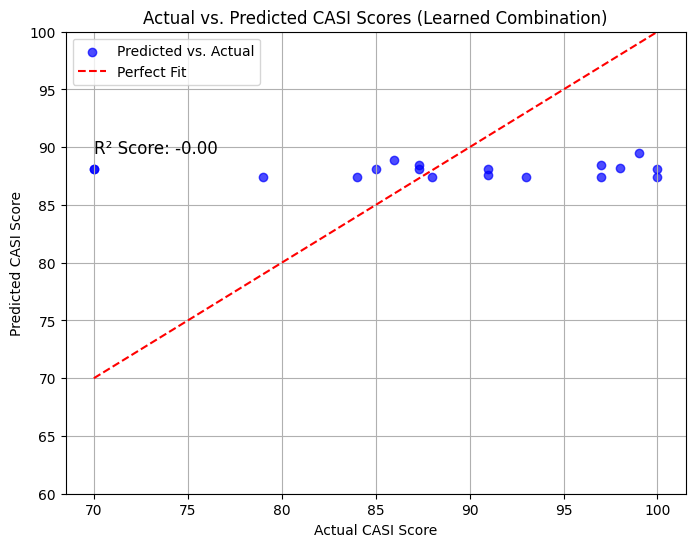

In [122]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs. Actual", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")
plt.ylim([60,100])
plt.xlabel("Actual CASI Score")
plt.ylabel("Predicted CASI Score")
plt.title("Actual vs. Predicted CASI Scores (Learned Combination)")
plt.legend()
plt.grid(True)
plt.text(min(y_test), max(y_pred), f"R² Score: {r2:.2f}", fontsize=12, color="black")
plt.show()